In [ ]:
# %%capture
# !pip install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import os
import yaml
from easydict import EasyDict
from utils.plots import plot_waveform, \
                        play_audio, \
                        plot_specgram
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

#### Load hyperparams
____

In [41]:
hp = EasyDict(yaml.load(open('./config/config.yaml'), Loader=yaml.FullLoader))
{k: ', '.join(v.keys()) for k, v in hp.items()}

{'embedder': 'num_mels, n_fft, emb_dim, lstm_hidden, lstm_layers, window, stride',
 'audio': 'n_fft, num_freq, sample_rate, hop_length, win_length, min_level_db, ref_level_db, preemphasis, power',
 'model': 'lstm_dim, fc1_dim, fc2_dim, activation',
 'data': 'train_url, test_url, train_size, test_size, audio_len',
 'form': 'input, refer, target, mixed',
 'train': 'batch_size, optimizer, adam, adabound',
 'log': 'chkpt_dir, log_dir'}

#### Prepare dataset
____

In [14]:
from datasets import LibriSpeechDatamodule

In [42]:
root = "./"
dm = LibriSpeechDatamodule(hp, root, hp.train.batch_size, download=True)
dm.setup()

Located 50000 examples totaling 41.7 hr in the train subset.
Located 5000 examples totaling 4.3 hr in the test subset.


#### Voice Separation
____

In [16]:
from model import VoiceEmbedder, VoiceSeparation, VoiceSeparationPL

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [43]:
embedder = VoiceEmbedder(hp)
embedder.load_state_dict(torch.load('embedder.pt'))
embedder.eval()

VoiceEmbedder(
  (lstm): LSTM(40, 768, num_layers=3, batch_first=True)
  (proj): LinearNorm(
    (linear_layer): Linear(in_features=768, out_features=256, bias=True)
  )
)

In [18]:
model = VoiceSeparation(hp)
model_wrapper = VoiceSeparationPL(hp, model, embedder)

In [19]:
log_dir = os.path.join(root, 'logs/')
logger = TensorBoardLogger(save_dir = log_dir)
checkpoint = ModelCheckpoint(dirpath = logger.log_dir, 
                             monitor='val/sdr', 
                             mode='max')

early_stop_callback = EarlyStopping(monitor="val/sdr",
                                    mode="max")

trainer = pl.Trainer(logger=logger,
                     devices="auto",
                     accelerator="auto",
                     gradient_clip_val=1,
                     max_epochs = 40,
                     limit_val_batches=0.25,
                     callbacks=[checkpoint, early_stop_callback])

In [ ]:
# Start trainig
trainer.fit(model = model_wrapper, datamodule = dm)

#### Test
---

In [20]:
# Load best saved model
best_model = 'best_model_relu.ckpt'
model_wrapper.load_state_dict(torch.load(best_model)['state_dict'])

# Test
trainer.test(model_wrapper, datamodule = dm)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

#### Evaluation
---

In [27]:
import random
from utils.audio import Audio

audio = Audio(hp)

res_path  = './results/'
os.makedirs(res_path, exist_ok=True)

In [37]:
sample_no = random.randrange(20)
sample_id = str(sample_no).zfill(6)
print("Sample audio id: ", sample_id)

refer_file = f'LibriSpeech/train/{sample_id}-refer.wav'
mixed_file = f'LibriSpeech/train/{sample_id}-mixed.wav'
target_file = f'LibriSpeech/train/{sample_id}-target.wav'
target_sr  = hp.audio.sample_rate

mixed_wav = audio.load(mixed_file)
target_wav = audio.load(target_file)
refer_wav  = audio.load(refer_file)

# Load model
# model_wrapper.load_state_dict(torch.load(best_model)['state_dict'])
model_wrapper.eval()
with torch.no_grad():
    output_wav = model_wrapper(mixed_wav, target_wav, refer_wav, mask='reg')

print('Mixed:')
play_audio(mixed_wav, target_sr)
print('Reference/d-vector:')
play_audio(refer_wav, target_sr)
print('Target')
play_audio(target_wav, target_sr)
print('Output')
play_audio(output_wav, target_sr)

Sample audio id:  000016
Mixed:


Reference/d-vector:


Target


Output


#### Reverse mask
____

In [35]:
with torch.no_grad():
    inv_wav = model_wrapper(mixed_wav, target_wav, refer_wav, mask='inv')
    reg_wav = model_wrapper(mixed_wav, target_wav, refer_wav, mask='reg')

play_audio(inv_wav, target_sr)
play_audio(reg_wav, target_sr)

#### Word Error Rate
____

In [30]:
from torchmetrics import WordErrorRate
wer = WordErrorRate()

In [38]:
# Save files for speech recognition
mixed_path = os.path.join(res_path, f'mixed_{sample_id}.flac')
output_path = os.path.join(res_path, f'target_{sample_id}.flac')
target_path = os.path.join(res_path, f'output_{sample_id}.flac')
torchaudio.save(mixed_path, mixed_wav, target_sr)
torchaudio.save(output_path, target_wav, target_sr)
torchaudio.save(target_path, output_wav, target_sr)

# Speech recognition
mixed_text = audio.recognize(mixed_path)
output_text = audio.recognize(output_path)
target_text = audio.recognize(target_path)
word_err_rate = wer(output_text, target_text).item()

print("Mixed SR: ", mixed_text)
print("Output SR: ", output_text)
print("Target SR: ", target_text)
print("WER: ", word_err_rate)

Mixed SR:  plenty of younger hands
Output SR:  she got up on her knees and wrung her hands
Target SR:  she got up on her knees and wrong her hands
WER:  0.10000000149011612


#### Visualization
___

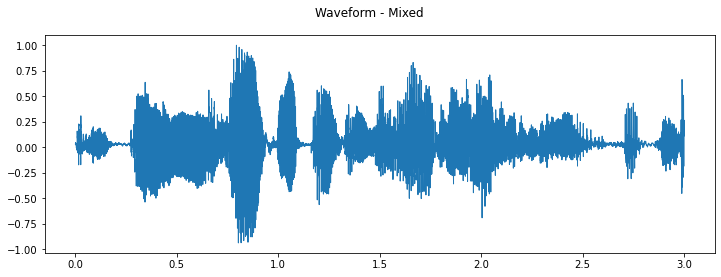

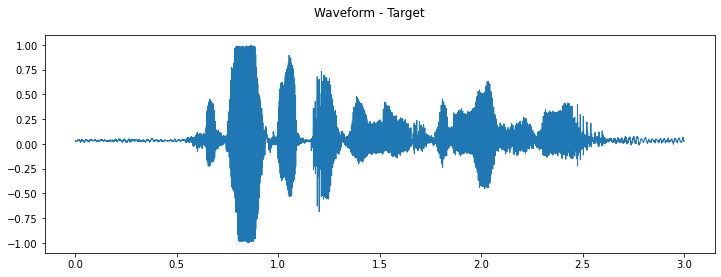

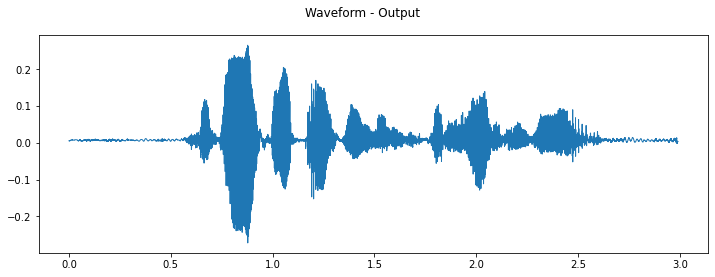

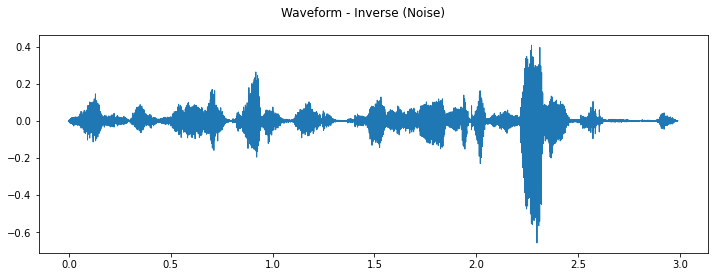

In [39]:
# Plot waveform
sr = hp.audio.sample_rate
plot_waveform(mixed_wav, sr, title="Waveform - Mixed", save=True)
plot_waveform(target_wav, sr, title="Waveform - Target", save=True)
plot_waveform(output_wav, sr, title="Waveform - Output", save=True)
plot_waveform(inv_wav, sr, title="Waveform - Inverse (Noise)", save=True)

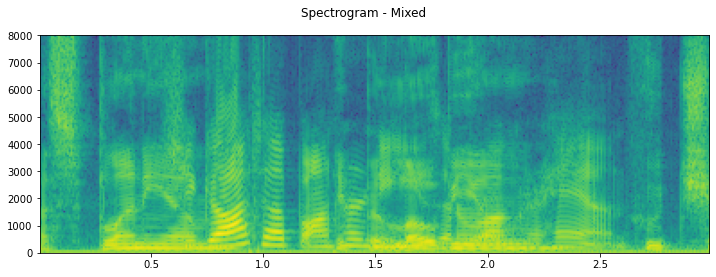

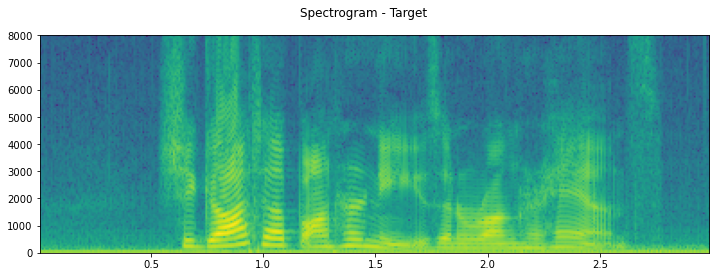

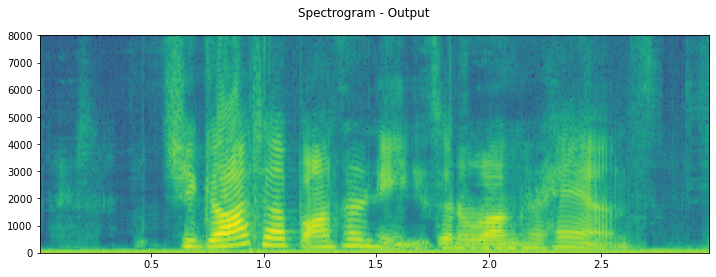

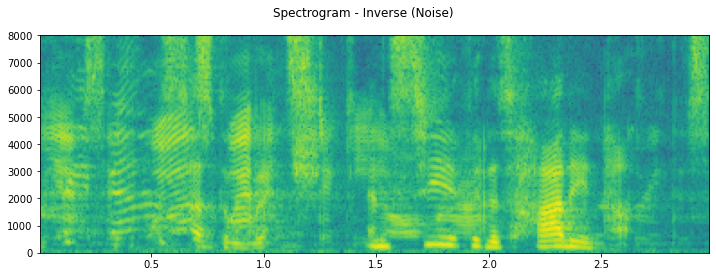

In [40]:
# Plot spectrogram
sr = hp.audio.sample_rate
save = False
plot_specgram(mixed_wav, sr, title="Spectrogram - Mixed", save=save)
plot_specgram(target_wav, sr, title="Spectrogram - Target", save=save)
plot_specgram(output_wav, sr, title="Spectrogram - Output", save=save)
plot_specgram(inv_wav, sr, title="Spectrogram - Inverse (Noise)", save=save)